In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import os
import pandas as pd
# tf.config.gpu.set_per_process_memory_growth(True)

In [2]:
_IMAGE_NET_TARGET_SIZE = (224, 224)

In [3]:
class Img2Vec(object):

    def __init__(self):
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    def get_vec(self, image_path):
        img = image.load_img(image_path, target_size=_IMAGE_NET_TARGET_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        return intermediate_output[0]

In [4]:
img2vec = Img2Vec()

In [5]:
image_paths = []
for root, dirs, files in os.walk("imagenet-mini/train/"):
    for file in files:
        if file.endswith(".JPEG"):
             image_paths.append(os.path.join(root, file))

In [6]:
x = 0
for i in image_paths:
    if x == 0:
        all_vectors = img2vec.get_vec(i).reshape(1, -1)
    else:
        to_append = img2vec.get_vec(i)
        to_append = to_append.reshape(1, -1)
        all_vectors = np.concatenate((all_vectors, to_append), axis=0)
    x += 1

In [7]:
to_save = pd.DataFrame(all_vectors)

In [11]:
to_save['image_path'] = image_paths

In [12]:
to_save.to_csv("imagenet_vectors.csv", index=False)

# Training a KNN Model for Retrieval

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
neigh = NearestNeighbors(n_neighbors=4, algorithm='brute', n_jobs=-1)

In [15]:
neigh.fit(all_vectors)

NearestNeighbors(algorithm='brute', n_jobs=-1, n_neighbors=4)

In [86]:
from matplotlib.pyplot import imshow, show
from PIL import Image

In [87]:
def show_image(path):
#     img = mpimg.imread(path)
#     imgplot = plt.imshow(img)
#     return imgplot
    image = Image.open(path)
    imshow(np.asarray(image))
    show()

In [88]:
neigh.kneighbors(all_vectors[0].reshape(1,-1), return_distance=False).flatten()

array([ 0, 12, 15, 13], dtype=int64)

In [89]:
def show_nearest_neighbors(index):
    to_query = to_save.iloc[[index]].values[0][:-1]
    indexes = neigh.kneighbors(to_query.reshape(1, -1), return_distance=False).flatten()
    show_image(to_save.image_path[index])
    for i in indexes[1:]:
        
        show_image(to_save.image_path[i])


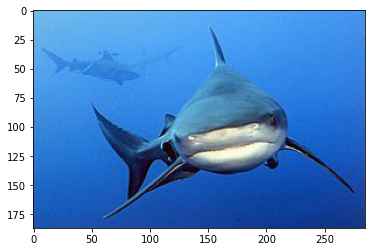

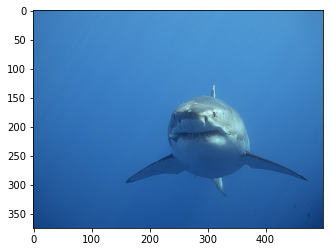

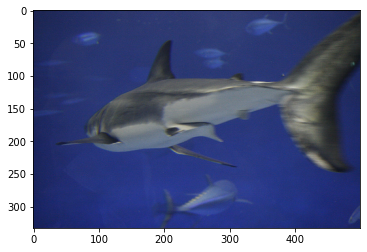

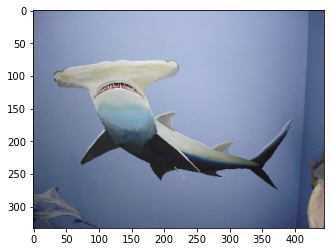

In [93]:
show_nearest_neighbors(100)